# Dimensionsreduzierung

In [44]:
%store -r columns_encoded
%store -r columns
%store -r data
%store -r data_encoded

columns_encoded = columns_encoded
columns = columns
data = data
data_encoded = data_encoded

In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

## Feature Selection

- Die Freitextfelder (d. h. "Lieblingssportart", "Lieblingsessen" & "Lieblings-Musiker*in") werden für die Dimensionsreduzierung entfernt
- Das neue Feature "Genre" bleibt hingegegen als One-Hot-Encoding bestehen, weil es hier einige Schnittmengen zwischen verschiedenen Datenpunkten gibt
- Begründungen
    - Durch die Umwandlung in numerische Werte per One-Hot-Encoding könnten diese theoretisch für Berechnung genutzt werden. Da fast alle Angaben aber nur einmal auftauchen, gibt es hier häufig starke Korrelationen
        - Bsp.: Eine Person hat als einzige eine bestimmte Lieblingssportart & Lieblingsessen angegeben, die dadurch vermeintlich stark miteinander korrelieren
    - Da immer nur eine Angabe pro "Lieblingssportart"/"Lieblingsessen"/"Lieblings-Musiker*in" möglich war, sind die Angaben bei allen anderen Features der Kategorie "0", wodurch der Informationsgehalt der Features sehr gering ist

- (Fast) Alle weiteren Features sind durch Fragestellung auf Werte von 1-5 beschränkt, wodurch keine weiteren Features offensichtlich irrelevant wären...

In [46]:
data_numerical = data.copy().select_dtypes(include='number')

### Skalieren der Daten

Da fast alle Fragen einen Zahlenraum von 1-5 vorgegeben hatten, müsste hierfür eigentlich keine Skalierung durchgeführt werden. Trotzdem skalieren wir die Daten, insb. aus den folgenden Gründen:

- Einzelne Features wie z. B. "Alter" machen eine Skalierung notwendig, da Clustering-Algorithmen sonst verschiedene Zahlenräume vergleichen würde
- Wenn in Zukunft weitere/andere Features (z. B. mit Zahlenraum von 1-10) eingeführt werden, sind die dargestellten Ansätze trotzdem langfristig nutzbar

In [47]:
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_numerical), columns=data_numerical.columns)

data_scaled.shape

(62, 56)

Durch Entfernen nicht-numerischer Features entfernte Spalten...

In [48]:
data_numerical.columns
set(data.columns) - set(data_numerical.columns)

{'Bitte gib hier ein Pseudonym ein und merke dir dieses\n(z.B. Kürzel, Zahlencode, etc.). Damit können nach Abschluss des Projektes der eigene "Datenpunkt" gefunden werden. Das Pseudonym wird für Andere sichtbar sein.',
 'Geschlecht',
 'Was ist dein Lieblingsessen? (nur eines angeben)',
 'Was ist deine Lieblingsband bzw. dein/e Lieblings-Musiker*in?\n(nur eine/n angeben)',
 'Was ist deine absolute Lieblingssportart?',
 'Welchem Studiengang fühlst du dich am meisten zugehörig?',
 'Welcher Funktion an der HSD fühlst du dich am meisten\nzugehörig?'}

## Dimensionsreduzierung auf Themenbereiche

- Bei Korrelationsanalyse wurde deutlich, dass in den jeweiligen Datenpunkten Features (bzw. Antworten zu Fragen) korrelieren, die inhaltlich ähnlich Interessen prüfen. Beispiele
    - "Wie sehr interessierst du dich für darstellende Künste wie Schauspiel, Tanz oder Gesang?" mit "Wie sehr interessierst du dich für bildende Kunst wie\nMalen, Zeichnen oder Fotografie?" -> Korrelation von 0.7
    - "Prokrastinierst du, wenn du lernen müsstest?" mit	"Wie häufig machst du Abgaben auf den letzten Drücker?" -> 0.5
- Daraus folgernd ist es naheliegend bzw. denkbar, die gestellten Fragen inhaltlich nach bestimmten Bereich zu gruppieren
- Um die Werte für jeden Themenbereich zu berechnen, könnte (da alle Fragen gleich skaliert sind) theoretisch einfach (arithmetische) Mittelwerte genutzt werden
- Alternativer Ansatz: Algorithmen zur Dimensionsreduzierung der jeweiligen Features der Themenbereiche nutzen

In [49]:
short_labels = ["alter", "geschlecht", "pseudonym", "funktion", "studiengang", "sportlichkeit", "lieblingssportart",
          "ernaehrung", "essengehen", "kochen", "feiern", "lieblingsessen", "musik", "lieblingsmusiker", "lesen", "schauspiel",
          "filme", "malen", "museumsbesuche", "videospiele", "social_media", "technologie", "astronomie", "naturwissenschaften",
          "freiwilligenarbeit", "soziales", "introvertiert", "fomo", "spontan", "verwirrt", "gluecklich", "geduldig", "streitlustig",
          "abenteuerlustig", "studienzweifel", "studium_zufriedenheit", "akademische_laufbahn", "lerngruppe", "prokrastinieren",
          "letzter_druecker", "neue_lebensmittel", "natur", "reisen", "handwerk", "sprachnachrichten", "geld",]

- Aufteilen der Features in die Themenbereiche "Demographie", "Kreativität", "Wissenschaft", "Soziales", "Studienverhalten" & "Persönlichkeit"

In [50]:
# Ursprüngliche Kategorien
# cat_demography = ["alter", "geschlecht", "pseudonym", "funktion", "studiengang"]

# Nach entfernen nicht-numerischer Werte
cat_demography = ("Demographie", ["alter"])

cat_sport = ("Sport", ["sportlichkeit", "ernaehrung", "essengehen", "kochen", "feiern",
 "sportarten_Basketball",
 "sportarten_Bouldern/Klettern",
 "sportarten_Football",
 "sportarten_Fußball",
 "sportarten_Handball",
 "sportarten_Hockey",
 "sportarten_Kampfsport",
 "sportarten_Leichtathletik",
 "sportarten_Reiten",
 "sportarten_Rennrad/Mountainbike",
 "sportarten_Schwimmen",
 "sportarten_Tanzen",
 "sportarten_Tennis",
 "sportarten_Volleyball",
 "sportarten_Wassersport",
 "sportarten_Wintersport",
 "sportarten_Yoga"])

cat_creativity =    ("Kreativität", ["musik", "lesen", "schauspiel", "filme", "malen", "museumsbesuche"])
cat_science =       ("Wissenschaft", ["videospiele", "social_media", "technologie", "astronomie", "naturwissenschaften"])
cat_social =        ("Soziales", ["freiwilligenarbeit", "soziales", "introvertiert", "fomo", "spontan", "verwirrt", "gluecklich", "geduldig", "streitlustig", "abenteuerlustig"])
cat_study =         ("Studienverhalten", [ "studienzweifel", "studium_zufriedenheit", "akademische_laufbahn", "lerngruppe", "prokrastinieren", "letzter_druecker"])
cat_personality =   ("Persönlichkeit", ["neue_lebensmittel", "natur", "reisen", "handwerk", "sprachnachrichten", "geld"])

all_categories = [cat_demography, cat_sport, cat_creativity, cat_science, cat_social, cat_study, cat_personality]
all_categories

[('Demographie', ['alter']),
 ('Sport',
  ['sportlichkeit',
   'ernaehrung',
   'essengehen',
   'kochen',
   'feiern',
   'sportarten_Basketball',
   'sportarten_Bouldern/Klettern',
   'sportarten_Football',
   'sportarten_Fußball',
   'sportarten_Handball',
   'sportarten_Hockey',
   'sportarten_Kampfsport',
   'sportarten_Leichtathletik',
   'sportarten_Reiten',
   'sportarten_Rennrad/Mountainbike',
   'sportarten_Schwimmen',
   'sportarten_Tanzen',
   'sportarten_Tennis',
   'sportarten_Volleyball',
   'sportarten_Wassersport',
   'sportarten_Wintersport',
   'sportarten_Yoga']),
 ('Kreativität',
  ['musik', 'lesen', 'schauspiel', 'filme', 'malen', 'museumsbesuche']),
 ('Wissenschaft',
  ['videospiele',
   'social_media',
   'technologie',
   'astronomie',
   'naturwissenschaften']),
 ('Soziales',
  ['freiwilligenarbeit',
   'soziales',
   'introvertiert',
   'fomo',
   'spontan',
   'verwirrt',
   'gluecklich',
   'geduldig',
   'streitlustig',
   'abenteuerlustig']),
 ('Studienve

In [51]:
# Helper-method to perform dimensionality reduction for given data and reduction model on predefined categories
# Input:
#   - data: DataFrame to be reduced
#   - model: Model which is used to perform reduction; Has to support the .fit_transform()-function
# Output: DataFrame, which used the given model to reduce the data to the predefined categories

def compute_categories(data, model):
    data_reduced = pd.DataFrame(columns=[category[0] for category in all_categories])
    for category in all_categories:
        model_trained = model.fit_transform(data[[columns[x] for x in category[1]]])
        data_reduced[category[0]] = model_trained[:,0]
    return data_reduced

### PCA

In [52]:
pca = PCA(n_components=1)

data_reduced_PCA = compute_categories(data_scaled, pca)
data_reduced_PCA

,Demographie,Sport,Kreativität,Wissenschaft,Soziales,Studienverhalten,Persönlichkeit
0,0.555073,-1.045241,-0.063565,-1.481797,0.405950,-1.635010,0.730060
1,0.105210,-0.775327,-0.850067,1.617876,-0.517746,-1.494638,-0.224172
2,-0.344653,2.200932,-1.671769,-0.669291,-1.797866,-1.035561,-1.429170
3,-0.569585,-1.387377,1.363657,0.105325,0.121731,-0.903822,1.204482
4,-0.344653,-0.566647,0.823353,-2.294303,-0.164162,2.018491,-0.347283
...,...,...,...,...,...,...,...
57,0.105210,2.237052,-3.023933,-1.345619,-0.158858,-2.657732,0.060967
58,-0.794517,0.332908,3.230977,-1.985446,0.103726,0.038180,0.662259
59,-0.119722,-0.531107,-0.778620,-1.918051,-0.498246,1.668469,2.008838
60,1.229868,0.838900,-3.183976,1.385794,-0.388389,-1.960236,1.699726


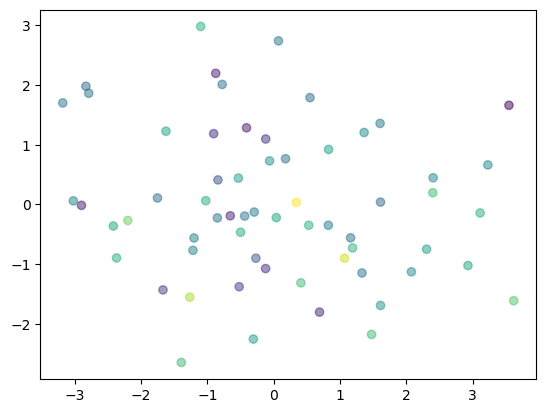

In [53]:
plt.scatter(data_reduced_PCA["Kreativität"], data_reduced_PCA["Persönlichkeit"], c=data_reduced_PCA["Soziales"], alpha=0.5)

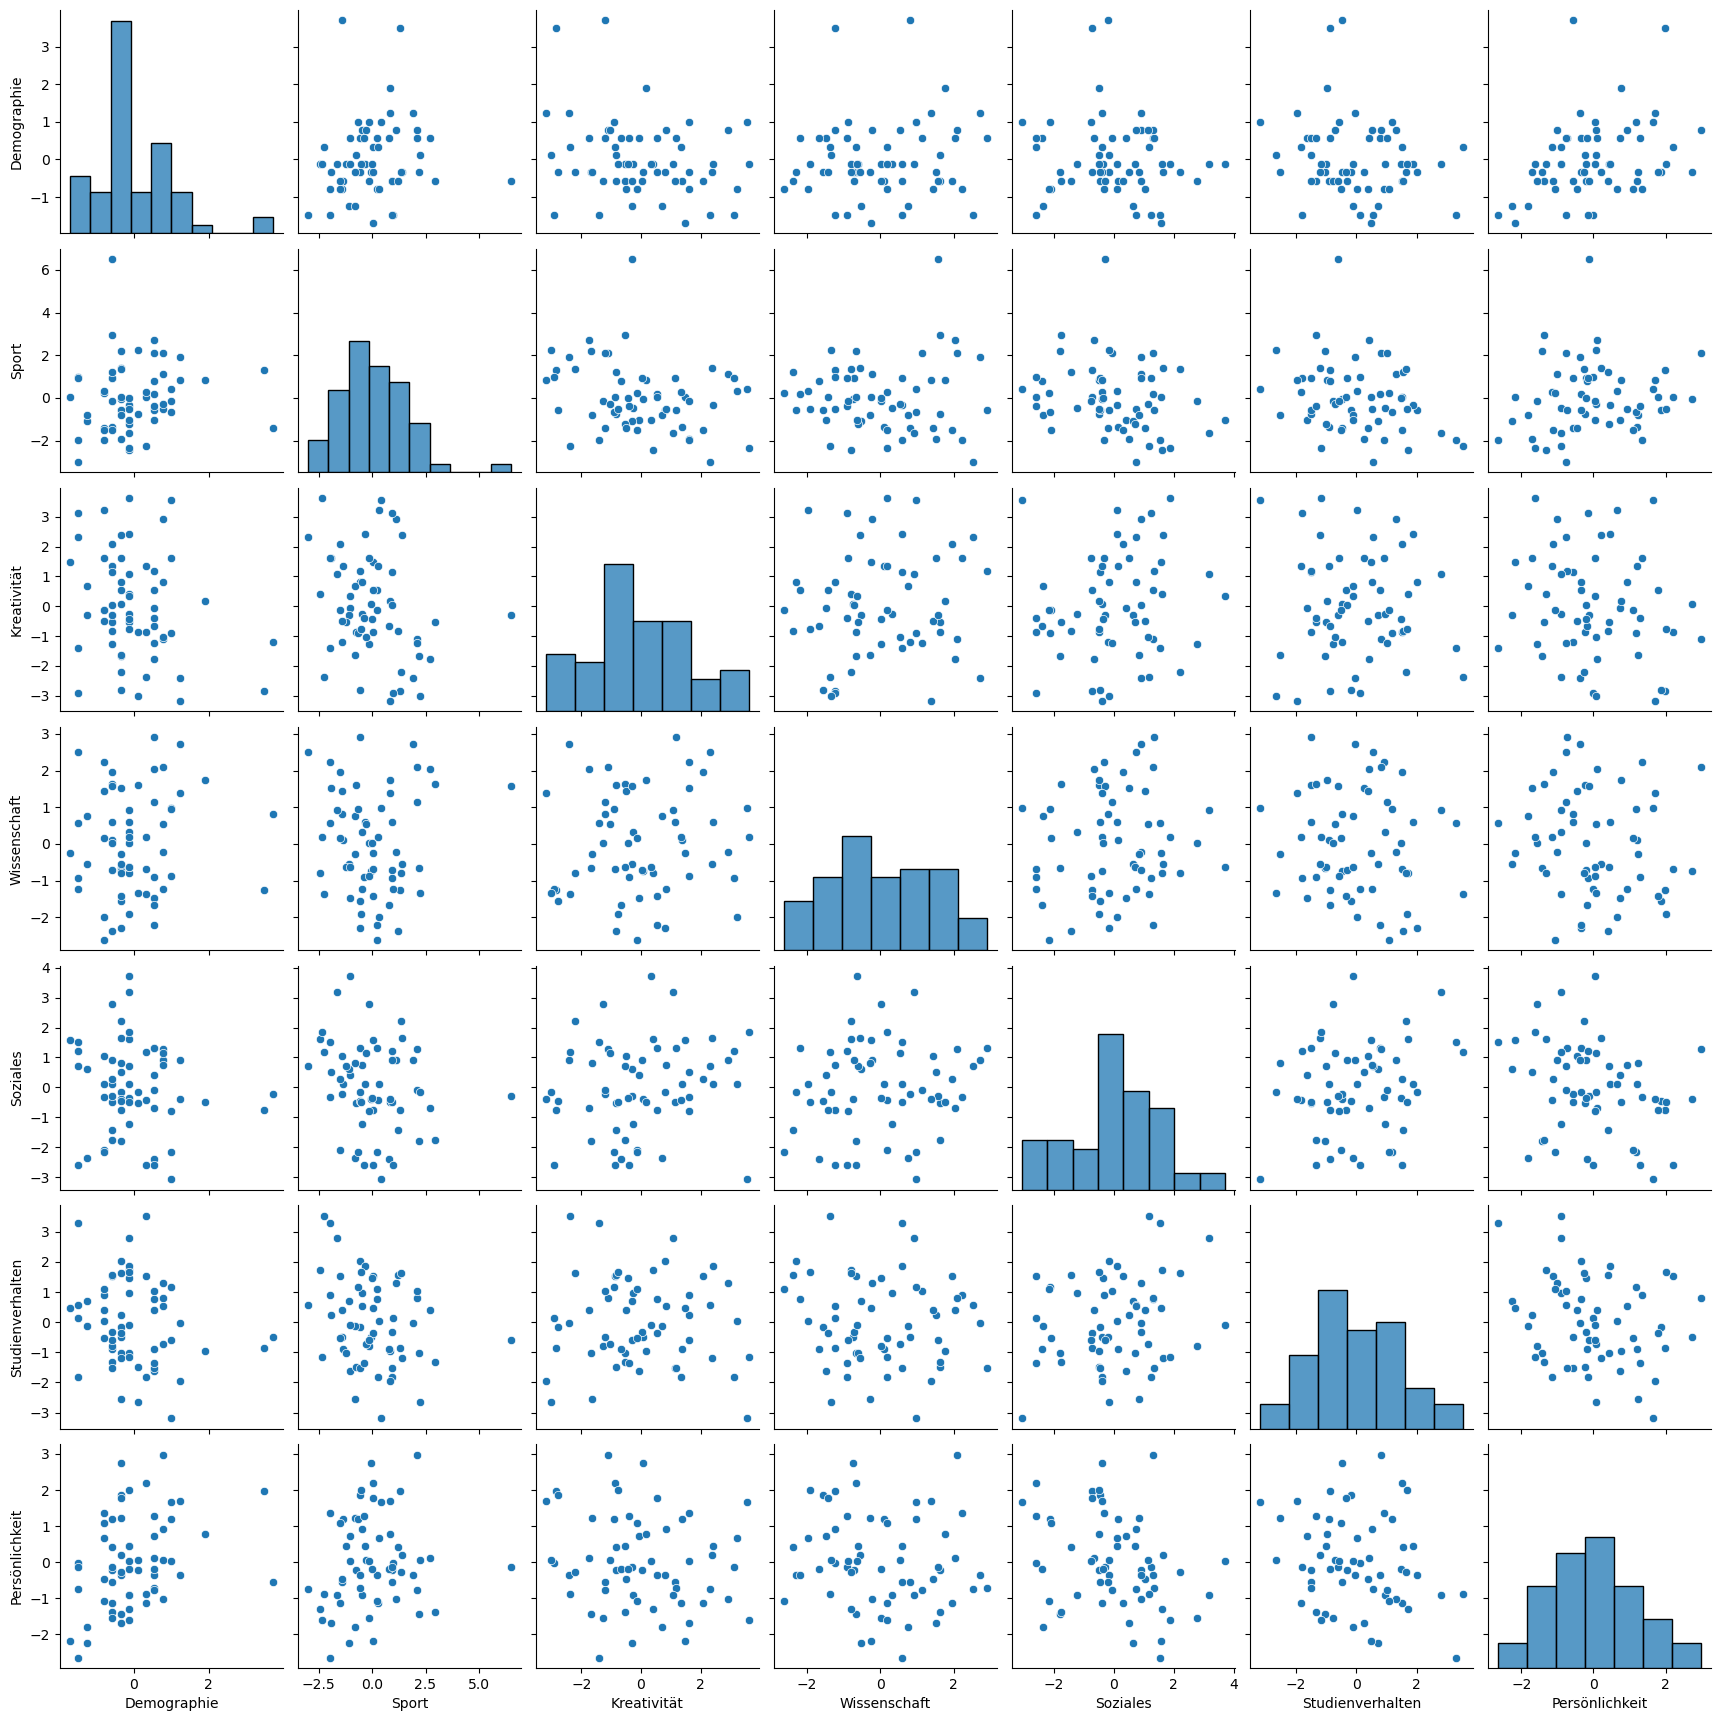

In [54]:
sb.pairplot(data_reduced_PCA)

### Kernel PCA

In [232]:
kpca = KernelPCA(n_components=1, kernel="rbf", gamma=1)

data_reduced_kPCA = compute_categories(data_scaled, kpca)
data_reduced_kPCA

,Demographie,Sport,Kreativität,Wissenschaft,Soziales,Studienverhalten,Persönlichkeit
0,0.649521,-0.029008,-0.072323,0.354519,-0.036199,-0.065395,0.008775
1,0.178282,-0.029008,-0.026302,-0.312151,-0.035542,0.680684,0.609035
2,-0.339394,-0.029008,-0.020185,0.394759,-0.035668,-0.023958,-0.008565
3,-0.503842,-0.029008,0.005427,0.013175,-0.037286,0.428626,0.026250
4,-0.339394,0.045535,-0.001480,-0.003015,-0.036315,-0.051439,0.008487
...,...,...,...,...,...,...,...
57,0.178282,-0.029008,-0.152107,0.038677,-0.035960,0.003806,-0.432017
58,-0.577100,-0.029185,-0.002770,-0.039669,-0.035643,-0.027941,0.040524
59,-0.099483,-0.029008,-0.067518,-0.023556,-0.035577,-0.026121,0.009827
60,0.720762,-0.029008,-0.175349,-0.085935,-0.037522,0.010576,0.052436


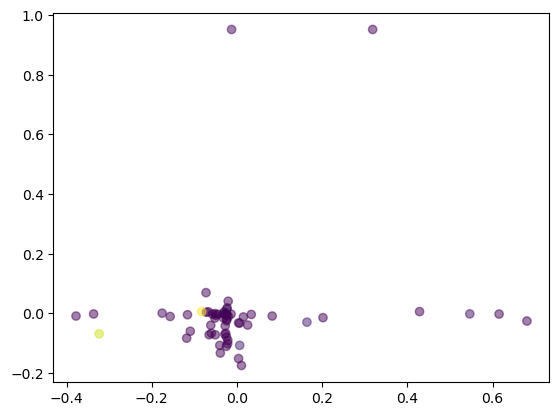

In [233]:
plt.scatter(data_reduced_kPCA["Studienverhalten"], data_reduced_kPCA["Kreativität"], c=data_reduced_kPCA["Soziales"], alpha=0.5)

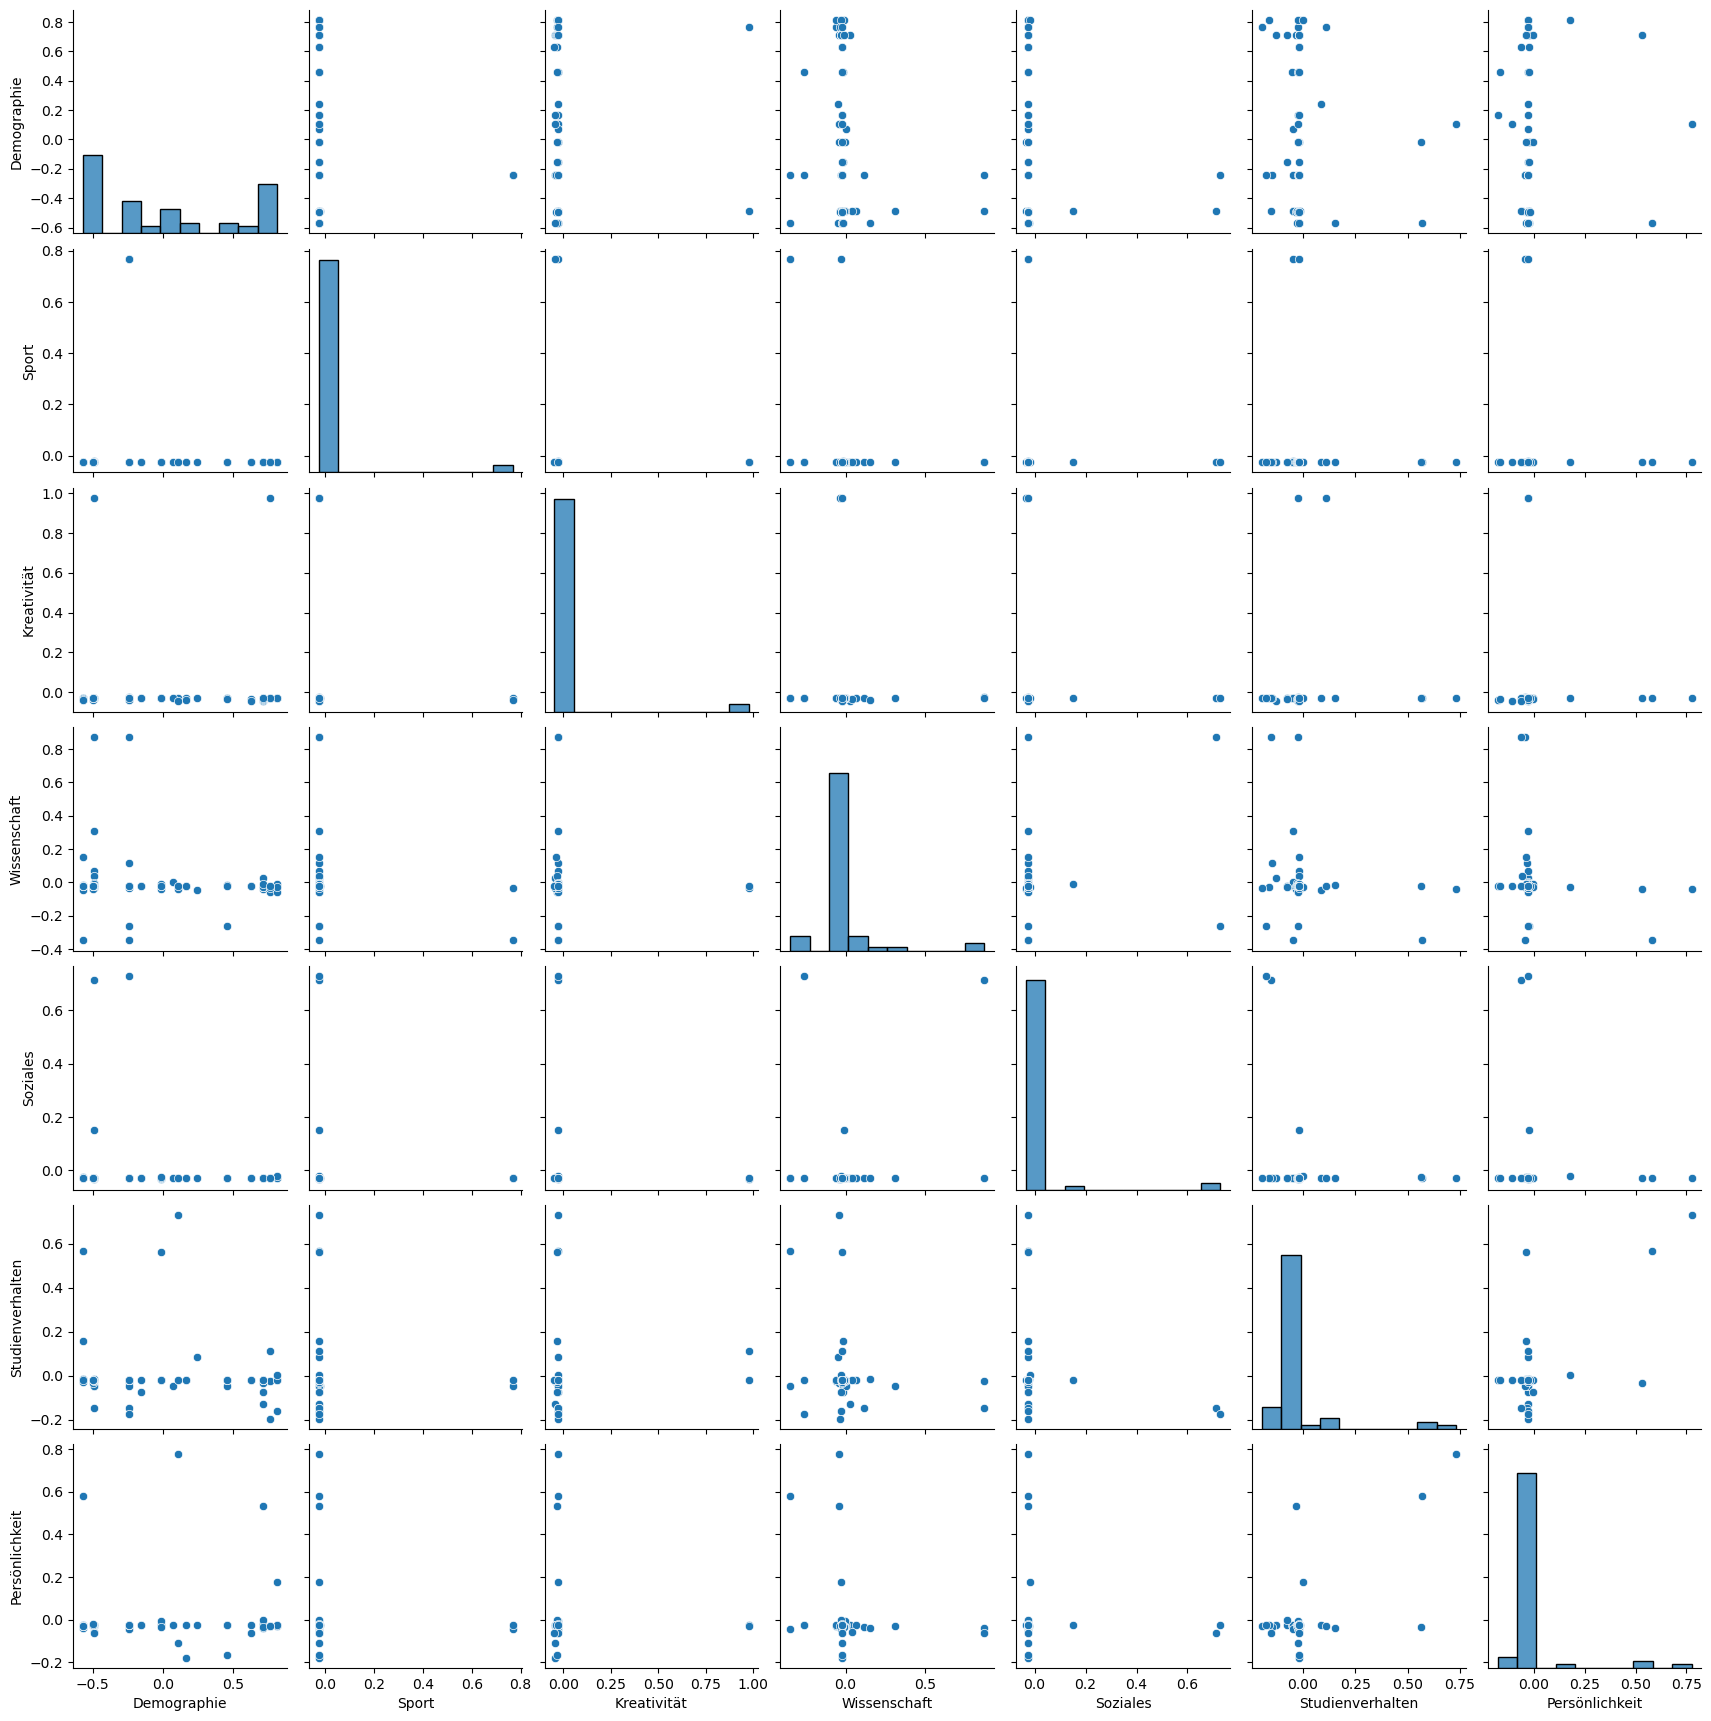

In [231]:
sb.pairplot(data_reduced_kPCA, diag_kws = {"bins": 10})

### t-SNE

In [58]:
tsne = TSNE(n_components=1, perplexity=50, random_state=0)

data_reduced_tsne = compute_categories(data_scaled, tsne)
data_reduced_tsne

,Demographie,Sport,Kreativität,Wissenschaft,Soziales,Studienverhalten,Persönlichkeit
0,-413.811157,0.830826,-1.127216,1.950580,0.876601,3.966310,4.031176
1,106.549850,0.846164,-1.470071,0.593220,0.639031,4.140762,3.190333
2,-276.811249,1.702856,-1.841605,1.627224,0.122093,3.923307,2.952388
3,23.524115,1.402032,-0.367725,1.306589,1.088734,4.314629,3.989380
4,-276.811249,0.998407,-0.533532,2.299694,0.741661,5.721639,3.008187
...,...,...,...,...,...,...,...
57,106.549850,-0.000097,-2.164667,2.031048,1.111992,3.775572,3.498195
58,-67.861549,0.827259,0.207322,2.501128,0.560037,4.833886,3.569905
59,-165.152588,0.832976,-1.430902,2.341027,0.603495,5.489359,4.237892
60,247.502502,1.056033,-2.182725,0.590345,0.800353,4.027880,4.029497


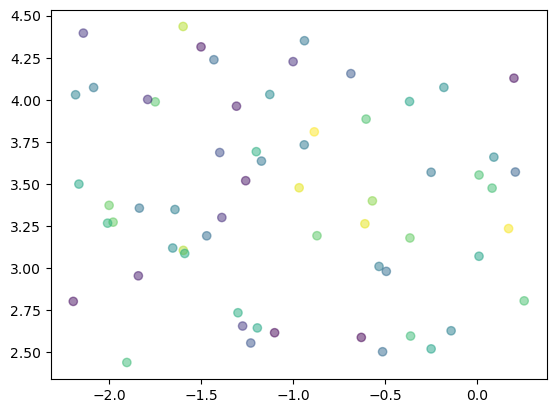

In [59]:
plt.scatter(data_reduced_tsne["Kreativität"], data_reduced_tsne["Persönlichkeit"], c=data_reduced_tsne["Soziales"], alpha=0.5)

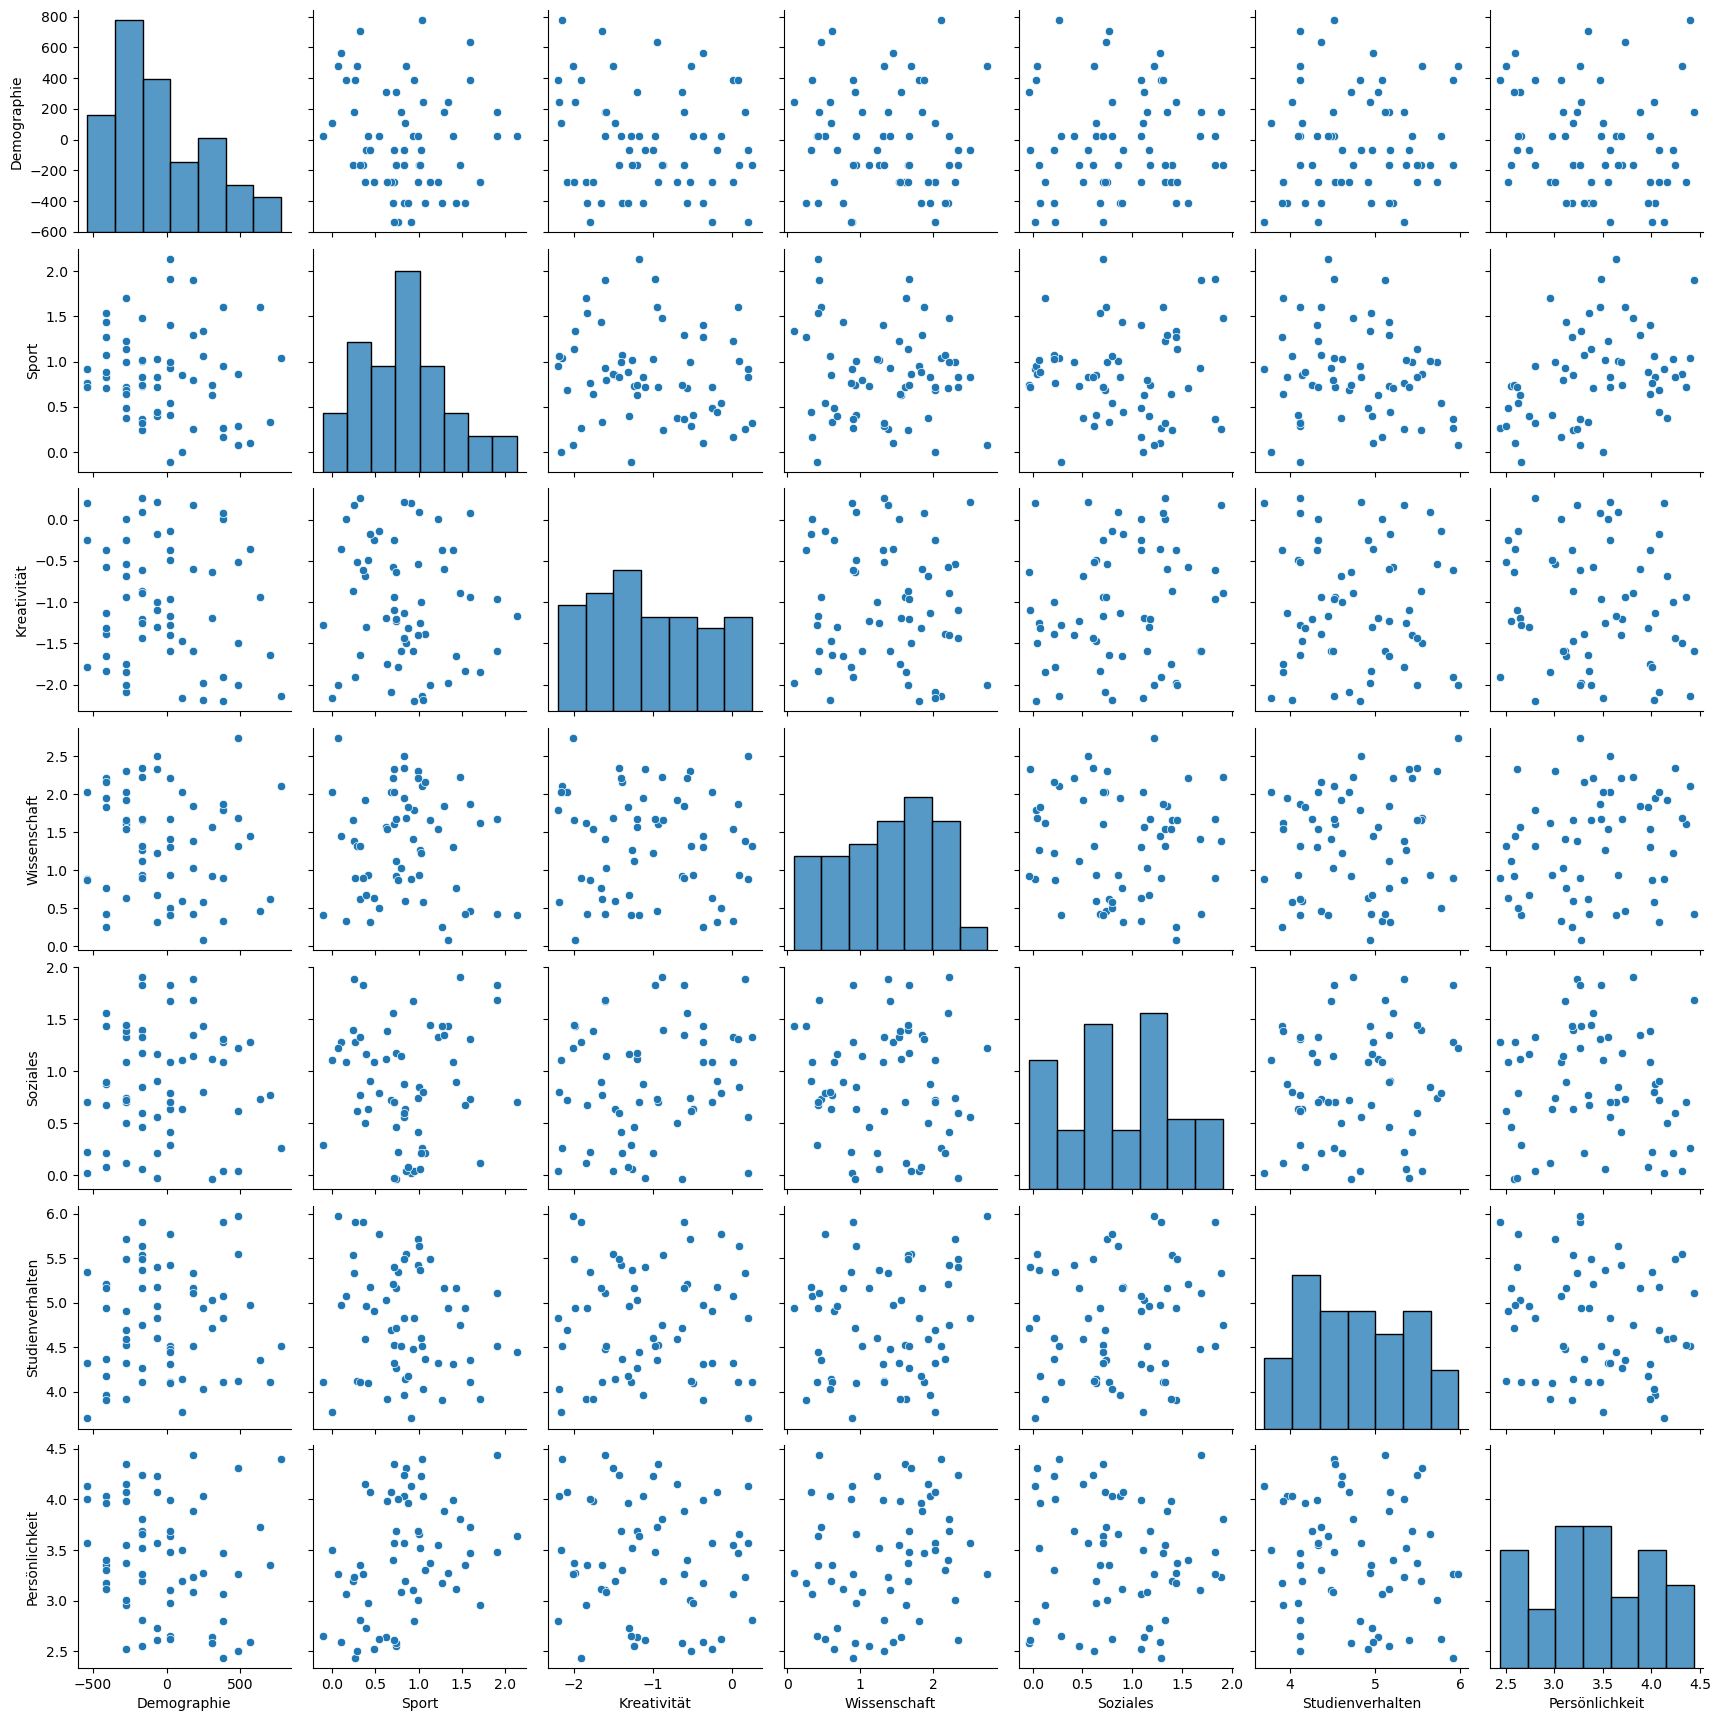

In [60]:
sb.pairplot(data_reduced_tsne)

# Anhang: Erste Versuche von Algrithmen zur Reduktionsreduzierung auf ursprünglichen Daten

## ("Standard") PCA

- Liefert vorrangig für lineare Daten gute Ergebnisse
- Da es sich um reale Daten mit vergleichsweise wenigen Messpunkten handelt, sind Ergebnisse nicht allzu aussagekräftig

- Erste Tests mit manuellem Ausprobieren...

In [61]:
# Angabe der gewünschten Dimensionen
pca = PCA(n_components=3)
X_pca = pca.fit_transform(data_scaled)
X_pca.shape

(62, 3)

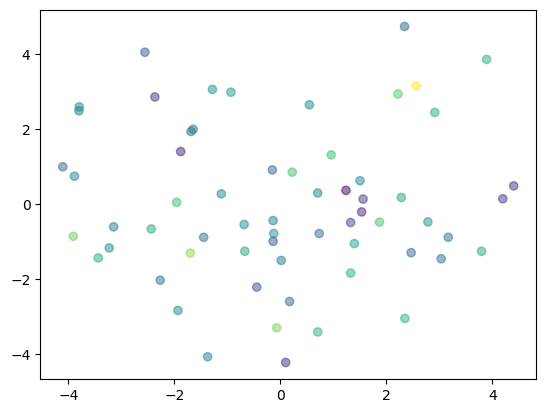

In [62]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=X_pca[:,2], alpha=0.5)

- Gridsearch für Parameterwahl
- TODO: Klären, ob man GridSearch hierfür überhaupt benutzen kann/soll???

In [144]:
# Angabe der gewünschten Dimensionen
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


def my_scorer(estimator, X, y=None):
    X_reduced = estimator.transform(X)
    X_preimage = estimator.inverse_transform(X_reduced)
    return -1 * mean_squared_error(X, X_preimage)

param_grid = [{
        "n_components": [1, 2, 3, 5, 10, 15, 25,]
    }]

X_pca= PCA()
# grid_search = GridSearchCV(X_pca, param_grid, cv=3, scoring='accuray')
# grid_search = GridSearchCV(X_pca, param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search = GridSearchCV(X_pca, param_grid, cv=3, scoring=my_scorer)
grid_search.fit(data_scaled)

grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

(PCA(n_components=25), {'n_components': 25}, -0.5031978579594708)

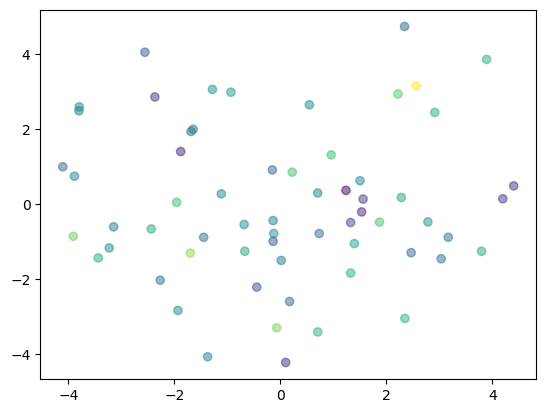

In [145]:
X_pca = grid_search.best_estimator_.fit_transform(data_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=X_pca[:,2], alpha=0.5)

## Kernel-PCA

- Allgemeine Hilfsfunktion zum Darstellen von mehreren Plots, die für die Parametersuche der folgenden Algorithmen genutzt wird

In [236]:
# Input:
#   - results:  Computation results as an array of tuples with the form ("<<plot title>>", [<<2-dimensional array]),
#               where the 2-dimensional array describes the x- & y-position of each data point
#   - figsize_columns: number of columns which are used to layout the plotted graphs. The number of rows is depending on the number of 'results' and the given 'figsize_columns'.
# Ouput: The plotted graphs which represent the given data from 'results'
import math

def display_reduction_results(results, figsize_columns):
    figsize_rows = math.ceil(len(results) / figsize_columns)
    fig, ax = plt.subplots(figsize_rows, figsize_columns, figsize=(15, 15))
    fig.tight_layout(pad=3)

    for i in range(len(results)):
        plt.subplot(figsize_rows, figsize_columns, i+1).scatter(results[i][1][:,0], results[i][1][:,1])
        plt.subplot(figsize_rows, figsize_columns, i+1).set_title(results[i][0])

- Sollte prinzipiell etwas bessere Ergebnisse als "Standard"-PCA liefern, da Features der Daten vermutlich nicht linear miteinander zusammenhängen

- Erste Tests mit manuellem Ausprobieren...

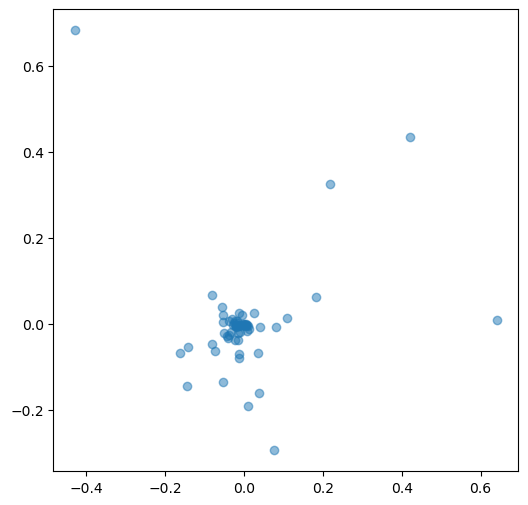

In [151]:
# Angabe der gewünschten Dimensionen
kpca = KernelPCA(n_components=2, kernel="rbf", gamma=2)
X_kpca = kpca.fit_transform(data_scaled)
X_kpca

fix, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_kpca[:,0], X_kpca[:,1], alpha=0.5)

- Gridsearch für Parameterwahl
- TODO: Klären, ob man GridSearch hierfür überhaupt benutzen kann/soll???

In [153]:
param_grid = [{
        "n_components": [1, 2, 3, 5, 10, 15, 25, 50],
        "gamma": np.linspace(0.03, 0.05, 10),
        "kernel": ["rbf", "sigmoid", "poly"]
    }]

X_kpca= KernelPCA(fit_inverse_transform=True, n_jobs=-1) 
# grid_search = GridSearchCV(X_kpca, param_grid, cv=3, scoring='accuracy')
grid_search = GridSearchCV(X_kpca, param_grid, cv=3, scoring=my_scorer)
grid_search.fit(data_scaled)

grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

c:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 684, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "c:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\decomposition\_kernel_pca.py", line 424, in fit
    self._fit_transform(K)
  File "c:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\decomposition\_kernel_pca.py", line 348, in _fit_transform
    self.eigenvalues_ = _check_psd_eigenvalues(

(KernelPCA(fit_inverse_transform=True, gamma=0.03, kernel='poly',
           n_components=50, n_jobs=-1),
 {'gamma': 0.03, 'kernel': 'poly', 'n_components': 50},
 -0.827305073010426)

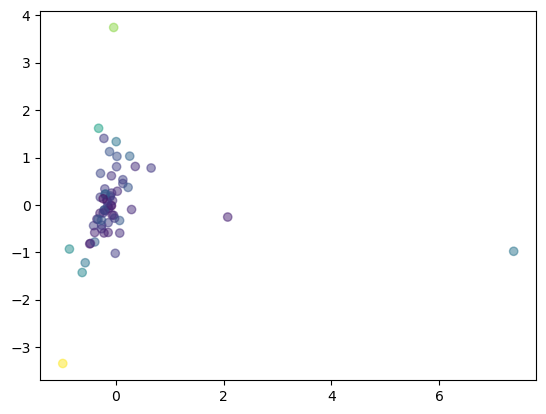

In [155]:
X_kpca = grid_search.best_estimator_.fit_transform(data_scaled)

plt.scatter(X_kpca[:,0], X_kpca[:,1], c=X_kpca[:,2], alpha=0.5)

In [217]:
n_components = [2, 3, 5, 10, 15]
gammas = [1, 2, 5, 10, 20]
# kernels = ["rbf", "sigmoid", "poly"]
kernels = ["rbf", "poly"]

kpca_results = []

for kernel in kernels:
    for gamma in gammas:
        for components in n_components:
            kpca = KernelPCA(n_components=components, gamma=gamma, kernel=kernel).fit_transform(data_scaled)
            parameter_string = "Comp: " + str(components) + ", Gamma: " + str(gamma) + ", Kernel: " + str(kernel)
            kpca_results.append((parameter_string, kpca))

In [218]:
len(kpca_results)

50

In [242]:
display_reduction_results(kpca_results[:25], 5)

ModuleNotFoundError: No module named 'local_helpers'

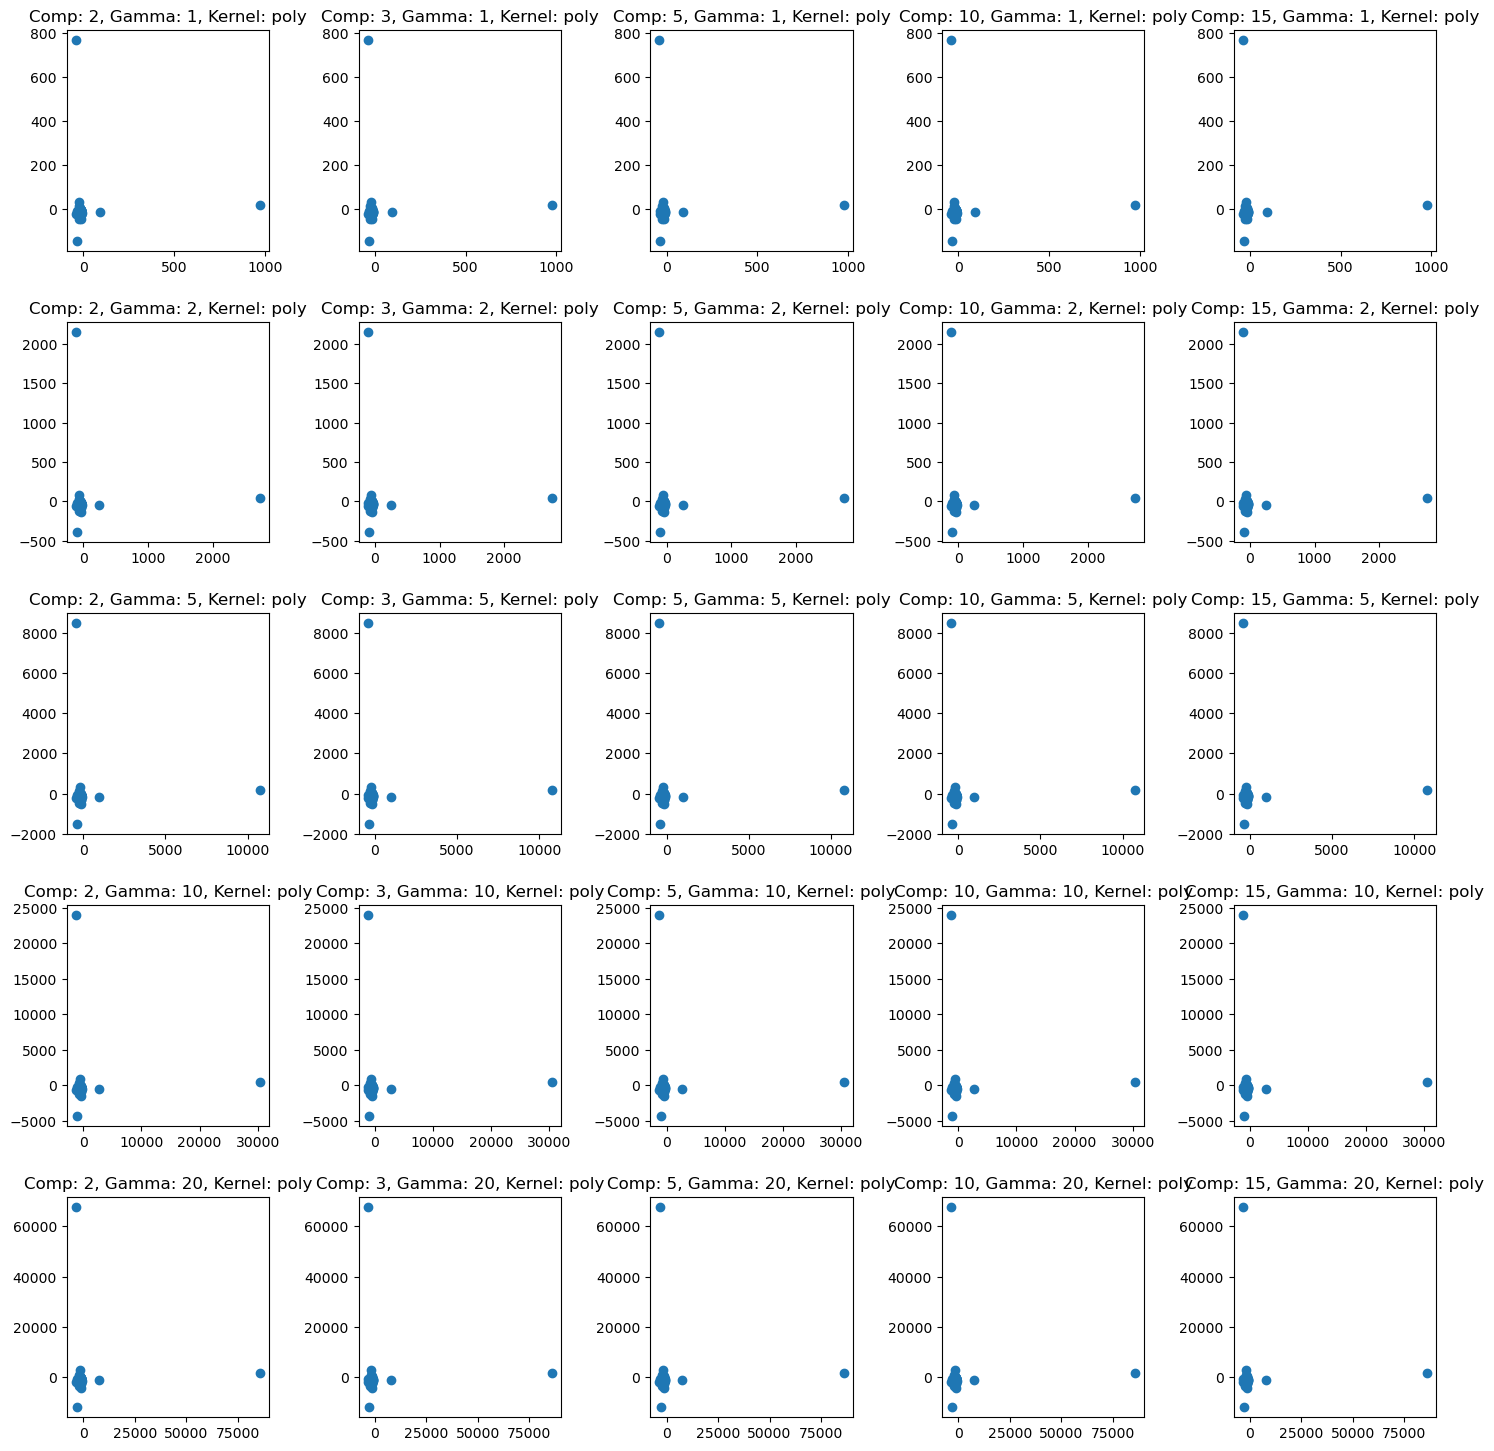

In [239]:
display_reduction_results(kpca_results[25:], 5)

## t-SNE

- Sollte prinzipiell etwas bessere Ergebnisse als "Standard"-PCA liefern, da Features der Daten vermutlich nicht linear miteinander zusammenhängen
- Ist zwar grundsätzlich nicht sehr performant; Dies ist aufgrund der geringen Größe des Datensatzes aber vernachlässigbar

- Erste Tests mit manuellem Ausprobieren...

In [100]:
tsne = TSNE(perplexity=50, random_state=0)
X_tsne = tsne.fit_transform(data_scaled)
X_tsne

array([[-0.69405687,  1.1682488 ],
       [-0.79765165,  1.3321284 ],
       [-1.5896147 ,  1.2729965 ],
       [ 0.03760719,  1.5755262 ],
       [-0.15373576,  0.89934576],
       [-0.18905172,  1.3240123 ],
       [-1.115397  ,  1.981078  ],
       [-0.80233693,  1.1024377 ],
       [-0.60014987,  2.2048895 ],
       [-0.59602654,  1.8922955 ],
       [-0.5328714 ,  0.6370003 ],
       [ 0.22217715,  1.0243018 ],
       [-1.406957  ,  0.5879549 ],
       [-0.08245122,  0.9666505 ],
       [ 0.11553487,  0.38720867],
       [-0.1406774 ,  0.7312206 ],
       [-0.94014287,  1.8153208 ],
       [-0.89052296,  1.3215387 ],
       [-1.3239375 ,  1.2296374 ],
       [-0.14236447,  0.6849229 ],
       [-0.4872988 ,  1.2417269 ],
       [-0.7400696 ,  0.877329  ],
       [-0.3275008 ,  0.4531935 ],
       [-0.6250821 ,  0.6666584 ],
       [ 0.10629334,  1.3150983 ],
       [-0.5960993 ,  0.50846195],
       [-0.8816482 ,  1.2725722 ],
       [-0.80599105,  0.7807571 ],
       [-0.63249993,

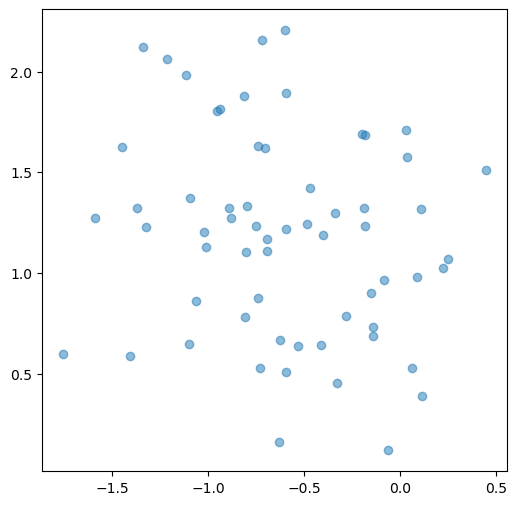

In [91]:
fix, ax = plt.subplots(figsize=(6,6))
ax.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.5)

- Gridsearch für Parameterwahl
- TODO: Klären, ob man GridSearch hierfür überhaupt benutzen kann/soll???

In [95]:
param_grid = [{
        "n_components": [1, 2, 3, 5, 10, 15, 25, 50],
        "perplexity": [5, 7, 10, 15, 20, 25, 30, 35, 40, 50],
        "early_exaggeration": [1, 2, 3, 5, 7, 10, 12, 15, 20]
    }]

tsne = TSNE(random_state=0)
grid_search = GridSearchCV(tsne, param_grid, cv=3, scoring=my_scorer)
grid_search.fit(data_scaled)

grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

c:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
  File "C:\Users\Konstantin\AppData\Local\Temp\ipykernel_3364\918805518.py", line 7, in my_scorer
    X_reduced = estimator.transform(X)
AttributeError: 'TSNE' object has no attribute 'transform'

  warnings.warn(
c:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Konstantin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(e

(TSNE(early_exaggeration=1, n_components=1, perplexity=5, random_state=0),
 {'early_exaggeration': 1, 'n_components': 1, 'perplexity': 5},
 nan)

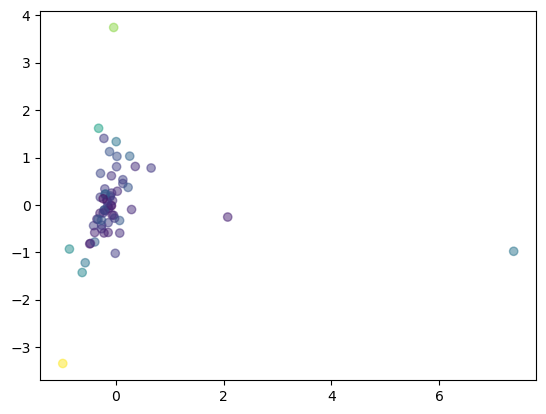

In [156]:
tsne = grid_search.best_estimator_.fit_transform(data_scaled)

plt.scatter(tsne[:,0], tsne[:,1], c=tsne[:,2], alpha=0.5)

In [163]:
perplexities = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60]

tsne_results = []

for perplexity in perplexities:
    tsne_results.append(TSNE(perplexity=perplexity, random_state=0).fit_transform(data_scaled))

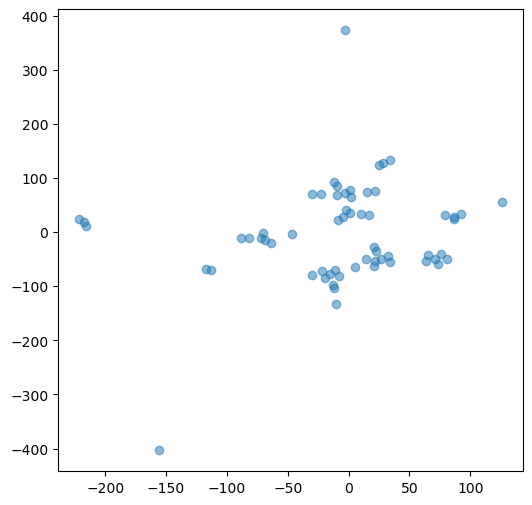

In [164]:
fix, ax = plt.subplots(figsize=(6,6))
ax.scatter(tsne_results[0][:,0], tsne_results[0][:,1], alpha=0.5)

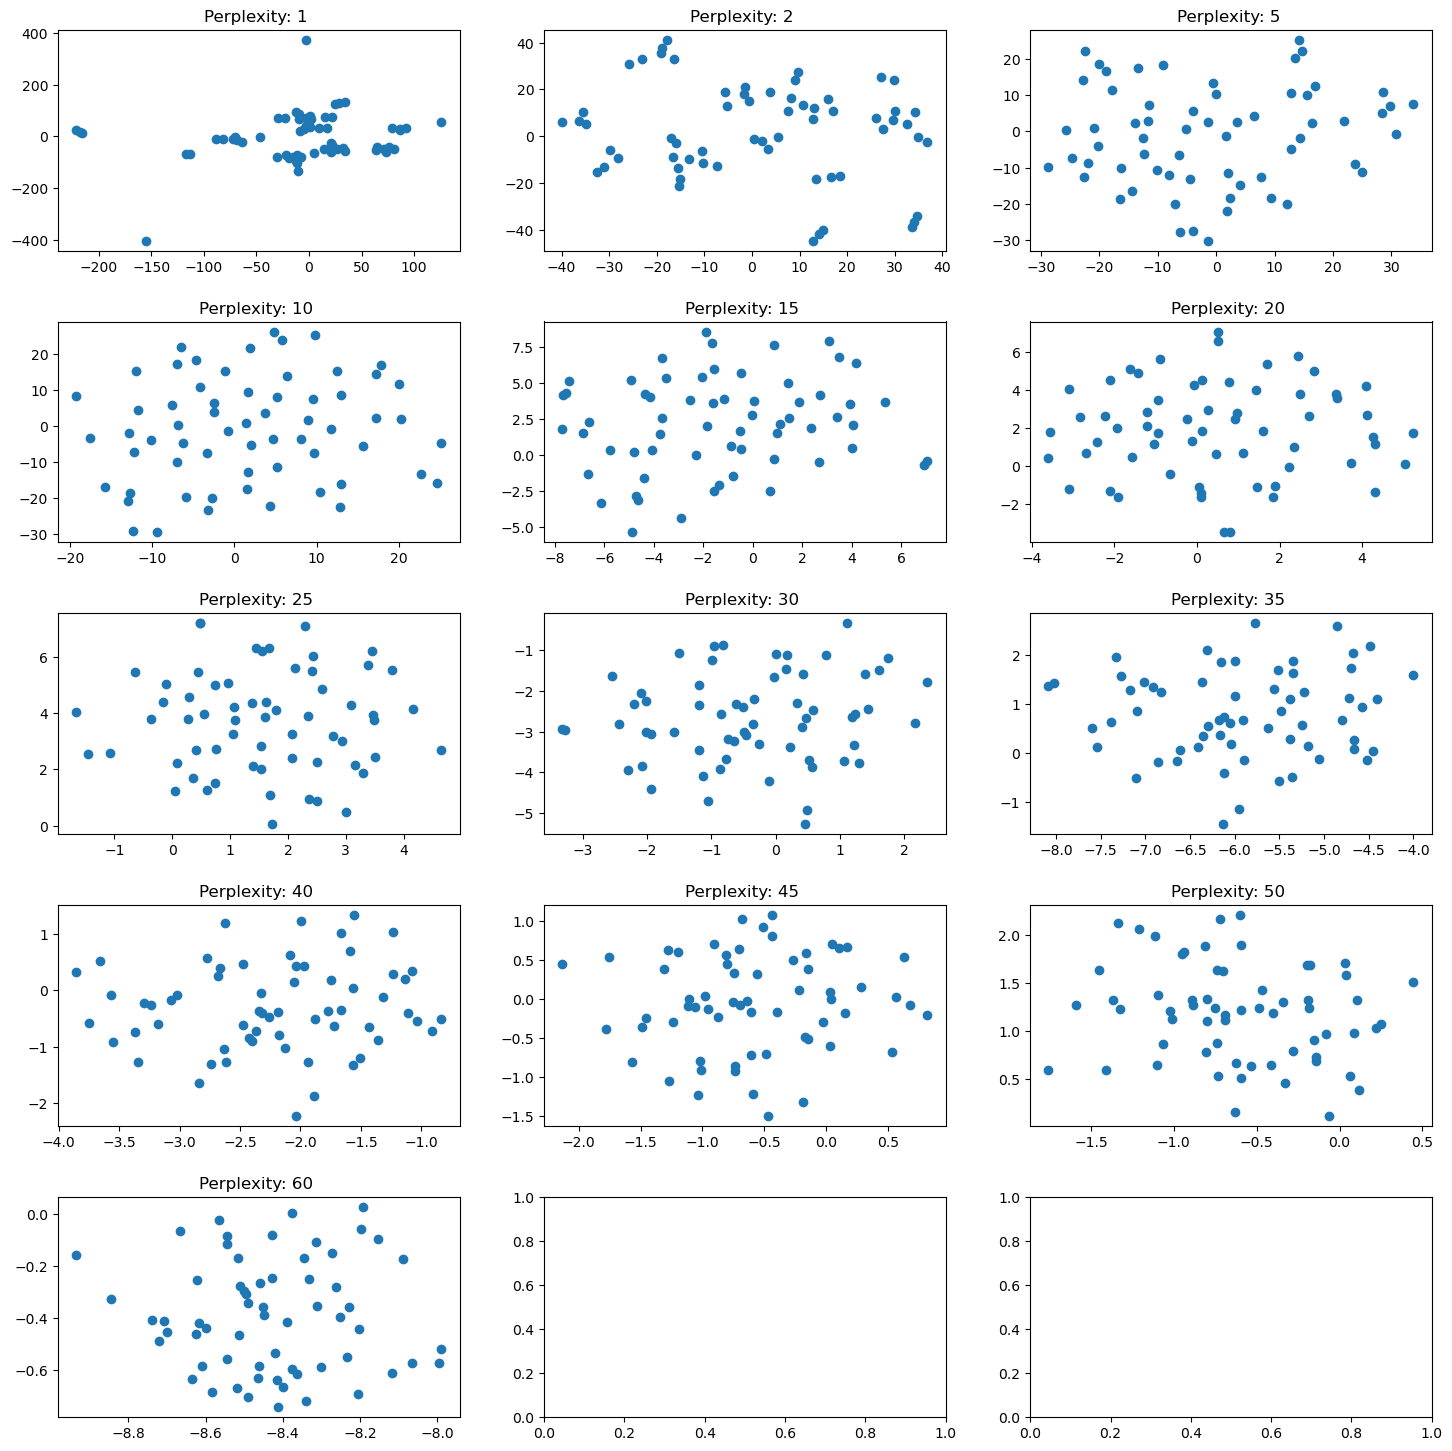

In [180]:
display_reduction_results(tsne_results, [("Perplexity", perplexities)], 3)

In [240]:
data_reduced_tsne = TSNE(perplexity=2, random_state=0).fit_transform(data_scaled)
%store data_reduced_tsne

Stored 'data_reduced_tsne' (ndarray)
